# Vortex near cylinder in potential flow

In [1]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
using Profile

clibrary(:colorbrewer)
default(grid = false)

In [2]:
mutable struct Vortex
    x::Real
    y::Real
    Γ::Real
end

In [3]:
function advect!(p::Vortex, u::Real, v::Real , Δt::Float64) where T
#     print("current position: $(p.x)\n")
#     print("velocity: $(v)\n")
#     print("updated position: $(p.x .+ v.*Δt)\n")
    p.x += u*Δt
    p.y += v*Δt
end

advect! (generic function with 1 method)

In [4]:
function streamfunctionSnapshot(u::VectorData,vortices_Γ,f)
    s = Nodes(Dual,(nx,ny));
    L⁻¹(w::T) where {T} = L\w;
    
    Hw = Regularize(u,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve potential flow 
    s .= L\s
    S₀ = transpose(oB)*(Sinv*oB);
    f .= Sinv*((S .- oB*transpose(oB)./S₀)*(Sinv*(Emat*s .+ ψb)) .+ Γ0.*oB./S₀);
    ψ₀ = -1/S₀*(Γ0 - transpose(oB)*Sinv*(Emat*s .+ ψb));
    s .= -(L\(Hmat*f)) .- s .+ ψ₀; 
    return s
    
    # Calculate velocity field
#     q .= curl(ψ)/(dx); 
end 

streamfunctionSnapshot (generic function with 1 method)

### Eulerian grid

In [5]:
nx = 32; ny = 32;
Lx = 4.0;
dx = Lx/(nx-2);
display(dx)
s = Nodes(Dual,(nx,ny));
q = Edges(Primal,(nx,ny));

L = plan_laplacian(size(s),with_inverse=true)
L⁻¹(s::T) where {T} = L\s;

0.13333333333333333

### Body

In [6]:
n = 50

R = 1.0
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))
println("Ratio of arc spacing to cell size = ",ds/dx)

# Move the circle
xc = 2.0; yc = 2.0
T = RigidTransform((xc,yc),0.0)
T(body)

X = VectorData(body.x,body.y)
f = ScalarData(X);
const oB = ones(length(X.u));

# The desired streamfunction on the circle surface
const ψb = ScalarData(1.0*ones(length(X.u)));

# The desired circulation about the circle
const Γ0 = 0;

Ratio of arc spacing to cell size = 0.9418577929396944


### Schur complement of 2-by-2 saddle system

In [7]:
E = Regularize(X,dx;issymmetric=true);
Hmat,Emat = RegularizationMatrix(E,f,s);
PS = SaddleSystem((s,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
S = Matrix(PS.S);
const Sinv = inv(S);

### Problem parameters

In [8]:
vortex_1 = Vortex(2.0,0.5,1.0)

vortices = Array{Vortex,1}()
push!(vortices,vortex_1)

# Start time
tloc = 0.0

0.0

Plot original positions

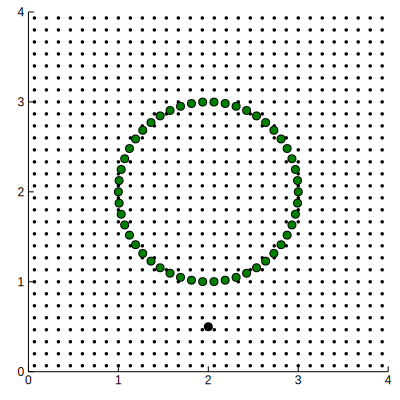

In [9]:
xg,yg = coordinates(s,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1,c=:black,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
scatter!((p->p.x).(vortices),(p->p.y).(vortices),c=:black)
scatter!(X.u,X.v,c=:green)
plot!(xlims=(0,Lx),ylims=(0,Lx))
display(p1)
savefig("vortex_near_cylinder.pdf")

Analytical period

In [10]:
R = yc-vortex_1.y
V = 1/(2π*R)-1/(2π*(R-1/R))
T = 2π*R/abs(V)

111.0330495122553

In [11]:
function rhs(vortices_loc::VectorData,params::Tuple{Nodes,Edges,ScalarData,ScalarData,Array{Float64}},t::Float64)

    s = params[1]
    q = params[2]
    vortices_Γ = params[3]
    f = params[4]
    Sinv = params[5]
        
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve potential flow 
    s .= L\s
    S₀ = transpose(oB)*(Sinv*oB);
    f .= Sinv*((S .- oB*transpose(oB)./S₀)*(Sinv*(Emat*s .+ ψb)) .+ Γ0.*oB./S₀);
    ψ₀ = -1/S₀*(Γ0 - transpose(oB)*Sinv*(Emat*s .+ ψb));
    s .= -(L\(Hmat*f)) .- s .+ ψ₀; 
    
    # Calculate velocity field
    q .= curl(s)/(dx);
    
    
    vel = VectorData(vortices_Γ)
    
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((s),q.u);
    Hw(vel.u,s)
    Fields.interpolate!((s),q.v);
    Hw(vel.v,s)
    
    return vel
    
end 

rhs (generic function with 1 method)

Benchmark

In [12]:
# @benchmark rhs(VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices]),(s,q,ScalarData([vortex.Γ for vortex in vortices]),f,Sinv),0.0)

### Time marching

In [13]:
function terminate_affect!(integrator)
   terminate!(integrator) 
end

function terminate_condition(u,t,integrator)
    u[1] - vortex_1.x
end
terminate_cb = ContinuousCallback(terminate_condition,nothing,terminate_affect!)

ContinuousCallback{typeof(terminate_condition),Nothing,typeof(terminate_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(terminate_condition, nothing, terminate_affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0)

In [14]:
tf = 111.03
tspan = (0.0,tf);#0.25
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
# u0 = [vortices_loc.u vortices_loc.v]
prob = ODEProblem(rhs,vortices_loc,tspan,(s,q,vortices_Γ,f,Sinv))

ODEProblem with uType VectorData{1} and tType Float64. In-place: false
timespan: (0.0, 111.03)
u0: [2.0, 0.5]

In [15]:
sol = @time solve(prob,dt=0.1,RK4(),callback=terminate_cb,dense=true)

  5.933179 seconds (15.52 M allocations: 827.193 MiB, 8.84% gc time)


retcode: Terminated
Interpolation: 3rd order Hermite
t: 66-element Array{Float64,1}:
  0.0               
  0.1               
  0.3966327014124904
  0.7894883493926204
  1.1770579713396179
  1.828301252309068 
  2.512813743073359 
  3.3396265438119905
  4.278424704499535 
  5.25888705332954  
  6.248834425188388 
  7.372628720585025 
  8.536528922063493 
  ⋮                 
 78.48807138828255  
 80.18136818440212  
 81.96060801717655  
 83.98287615470917  
 85.88583918471315  
 87.65564401655959  
 89.43953037370191  
 91.22800680201513  
 93.02302198822831  
 94.78085398757955  
 94.99754083969002  
 94.99754083969002  
u: 66-element Array{VectorData{1},1}:
 [2.0, 0.5]         
 [1.98961, 0.500034]
 [1.95877, 0.500536]
 [1.91791, 0.502097]
 [1.87772, 0.504623]
 [1.81061, 0.511141]
 [1.7406, 0.520966] 
 [1.65734, 0.536881]
 [1.56473, 0.560148]
 [1.47062, 0.590244]
 [1.37885, 0.626421]
 [1.27882, 0.674152]
 [1.18033, 0.730719]
 ⋮                  
 [3.33193, 1.29028] 
 [3.24852, 1.148

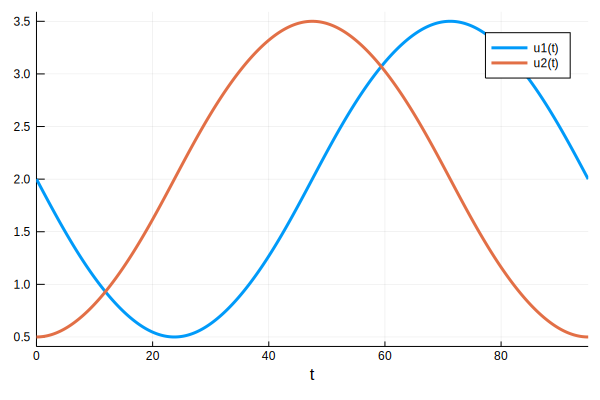

In [16]:
plot(sol,grid=true)
# savefig("vortex_pair_rotating_goza_coordinates.pdf")

In [17]:
sol.t

66-element Array{Float64,1}:
  0.0               
  0.1               
  0.3966327014124904
  0.7894883493926204
  1.1770579713396179
  1.828301252309068 
  2.512813743073359 
  3.3396265438119905
  4.278424704499535 
  5.25888705332954  
  6.248834425188388 
  7.372628720585025 
  8.536528922063493 
  ⋮                 
 78.48807138828255  
 80.18136818440212  
 81.96060801717655  
 83.98287615470917  
 85.88583918471315  
 87.65564401655959  
 89.43953037370191  
 91.22800680201513  
 93.02302198822831  
 94.78085398757955  
 94.99754083969002  
 94.99754083969002  

In [18]:
ψ_array = typeof(s)[]
tstamps = range(0,stop=sol.t[end],length=100)
for i in 1:length(tstamps)
    vortices_location = VectorData([sol(tstamps[i])[1]],[sol(tstamps[i])[2]])
    push!(ψ_array,streamfunctionSnapshot(vortices_location,vortices_Γ,f))
end

In [19]:
contourlevels = range(-.87,stop=1.516,length=100)
maximum(ψ_array[1])

1.4166410346075944

In [26]:
i=1
scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false)
plot!(xg,yg,ψ_array[i],levels=contourlevels,c=:YlOrRd,linewidth=2,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
scatter!([sol(tstamps[i])[1]],[sol(tstamps[i])[2]],markershape=:circle,markersize=0.5,ratio=1)
plot!(body,fillcolor=:white,fillrange=0,fillalpha=1,linecolor=:white)
scatter!(X.u,X.v,c=:green)
savefig("vortex_near_cylinder_streamfunction.pdf")
# sol(tstamps[i])[1]

In [28]:
anim = @animate for i=1:length(tstamps)
    scatter(first.(coord)[:],last.(coord)[:],markercolor=:black,markerstrokecolor=:black,ratio=:equal,markersize=0.5,legend=false)
    plot!(xg,yg,ψ_array[i],levels=contourlevels,c=:YlOrRd,linewidth=2,xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
    scatter!([sol(tstamps[i])[1]],[sol(tstamps[i])[2]],markershape=:circle,markersize=0.5,ratio=1)
    plot!(body,fillcolor=:white,fillrange=0,fillalpha=1,linecolor=:white)
    scatter!(X.u,X.v,c=:green)
end
gif(anim, "vortex_near_cylinder.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/vortex_near_cylinder.gif
└ @ Plots /Users/beckers/.julia/packages/Plots/l0VjU/src/animation.jl:90


Plots.AnimatedGif("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl/notebooks/vortex_near_cylinder.gif")

### Plot results

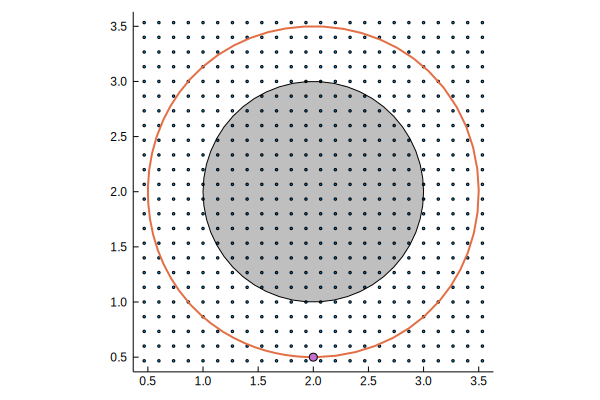

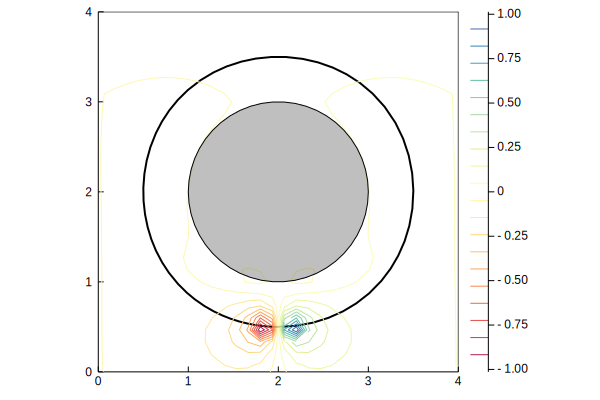

In [17]:
xg,yg = coordinates(s,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
plot!(sol,vars=(1,2),lw=2)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
scatter!([sol[end][1]],[sol[end][2]])
xlims!(minimum(sol[1,:])-1*dx,maximum(sol[1,:])+1*dx)
ylims!(minimum(sol[2,:])-1*dx,maximum(sol[2,:])+1*dx)

p4 = plot(sol,vars=(1,2),lw=2,color=:black)
plot!(xg,yg,s,levels=20);
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
plot!(xlims=(0,Lx),ylims=(0,Lx));
# savefig("vortex_pair_rotating_goza.pdf")

display(p1)

display(p4)

Period

In [52]:
R = yc-vortex_1.y
V = 1/(2π*R)-1/(2π*(R-1/R))
T = 2π*R/abs(V)

111.0330495122553

In [38]:
yc

2.0

In [43]:
A = rand(100,100); B = rand(100,100); C = rand(100,100);
D = zeros(100,100);

In [44]:
testFunction!(D,A,B,C) = @. D = A + B + C
@benchmark testFunction!(D,A,B,C)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.748 μs (0.00% GC)
  median time:      4.789 μs (0.00% GC)
  mean time:        4.812 μs (0.00% GC)
  maximum time:     10.691 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [46]:
@benchmark D = *(A',B,A)

BenchmarkTools.Trial: 
  memory estimate:  156.42 KiB
  allocs estimate:  5
  --------------
  minimum time:     68.378 μs (0.00% GC)
  median time:      120.945 μs (0.00% GC)
  mean time:        165.723 μs (18.80% GC)
  maximum time:     10.969 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [65]:
testFunction2!(D) = D = oB'*D*oB
testFunction3!(D) = D = *(oB',D,oB)

testFunction3! (generic function with 1 method)

In [66]:
@benchmark testFunction2!(D)

BenchmarkTools.Trial: 
  memory estimate:  1.78 KiB
  allocs estimate:  2
  --------------
  minimum time:     2.945 μs (0.00% GC)
  median time:      3.680 μs (0.00% GC)
  mean time:        4.529 μs (3.22% GC)
  maximum time:     1.106 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [67]:
@benchmark testFunction3!(D)

BenchmarkTools.Trial: 
  memory estimate:  1.78 KiB
  allocs estimate:  2
  --------------
  minimum time:     2.939 μs (0.00% GC)
  median time:      3.747 μs (0.00% GC)
  mean time:        4.806 μs (3.22% GC)
  maximum time:     1.146 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [7]:
typeof(Sinv)

UndefVarError: UndefVarError: Sinv not defined

In [ ]:
function rhs(vortices_loc::VectorData,params::Tuple{Nodes,Edges,ScalarData,VectorData},t::Float64)

    s = params[1]
    q = params[2]
    vortices_Γ = params[3]
    X = params[4]
    f = ScalarData(X);
    
    s .= L\s
    
#     L⁻¹(s::T) where {T} = L\s;
    
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve potential flow
    E = Regularize(X,dx;issymmetric=true);
    Hmat,Emat = RegularizationMatrix(E,f,s);
    PS = SaddleSystem((s,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
    S = Symmetric(Matrix(PS.S));
    Sinv = inv(S)
    S₀ = transpose(oB)*(Sinv*oB);
    f .= Sinv*((S .- oB*transpose(oB)./S₀)*(Sinv*(Emat*s .+ ψb)) .+ Γ0.*oB./S₀);
#     ψ₀ = -1/S₀*(Γ0 - transpose(oB)*Sinv*(Emat*s .+ ψb));
    ψ₀ = -1/S₀*(Γ0 - *(transpose(oB),Sinv,(Emat*s .+ ψb)));
    s .= -(L\(Hmat*f)) .- s .+ ψ₀; 
    
    # Calculate velocity field
    q .= curl(s)/(dx);
    
    
    vel = VectorData(vortices_Γ)
    
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((s),q.u);
    Hw(vel.u,s)
    Fields.interpolate!((s),q.v);
    Hw(vel.v,s)
    
    return vel
    
end 

In [30]:
matA=[1 0;1 1]

2×2 Array{Int64,2}:
 1  0
 1  1

In [32]:
res = svd(matA)

SVD{Float64,Float64,Array{Float64,2}}([-0.525731 -0.850651; -0.850651 0.525731], [1.61803, 0.618034], [-0.850651 -0.525731; -0.525731 0.850651])

In [33]:
res.S

2-element Array{Float64,1}:
 1.6180339887498951
 0.6180339887498947

In [23]:
sqrt((10002-sqrt(10002^2-4))/2)

0.009999000198082463

In [35]:
sqrt(0.5*(3-sqrt(5)))

0.6180339887498948

In [37]:
# w_i_tilde = [0.534522;0.801784;1.06904;1.33631];
# w_i_bar = [0.267261;0.267261;0.267261;0.267261];
# sqrt(dot(w_i_tilde, w_i_bar) - (1^2) - (1^2));

DomainError: DomainError with -1.0000012757839998:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [43]:
M = [0.5 0 0 0;0 0.333333 0 0;0 0 0.25 0;0 0 0 0.2];
A = [2 0 0 0;0 3 0 0;0 0 4 0;0 0 0 5];
b = A*[1;1;1;1]

4-element Array{Int64,1}:
 2
 3
 4
 5

In [101]:
A = [1 1;0 1];
C = [1 1];
# u = 1/10*[1;2;3;4]
y = [0;2;4;6];
M = [1 1; 1 2; 1 3; 1 4]
xp = [-2; 2]

2-element Array{Int64,1}:
 -2
  2

In [99]:
for i in 1:4
    xp = A*xp
    y = C*xp
    print(y)
end

[2][4][6][8]

In [102]:
M\y

2-element Array{Float64,1}:
 -1.9999999999999996
  1.9999999999999996

In [90]:
M*u

2-element Array{Float64,1}:
 1.0
 1.0

In [91]:
M*[0;0.5;0;0.5]

2-element Array{Float64,1}:
 1.0
 1.0